<a href="https://colab.research.google.com/github/ludwigwittgenstein2/Research/blob/master/Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transformer Model 

#Architecture

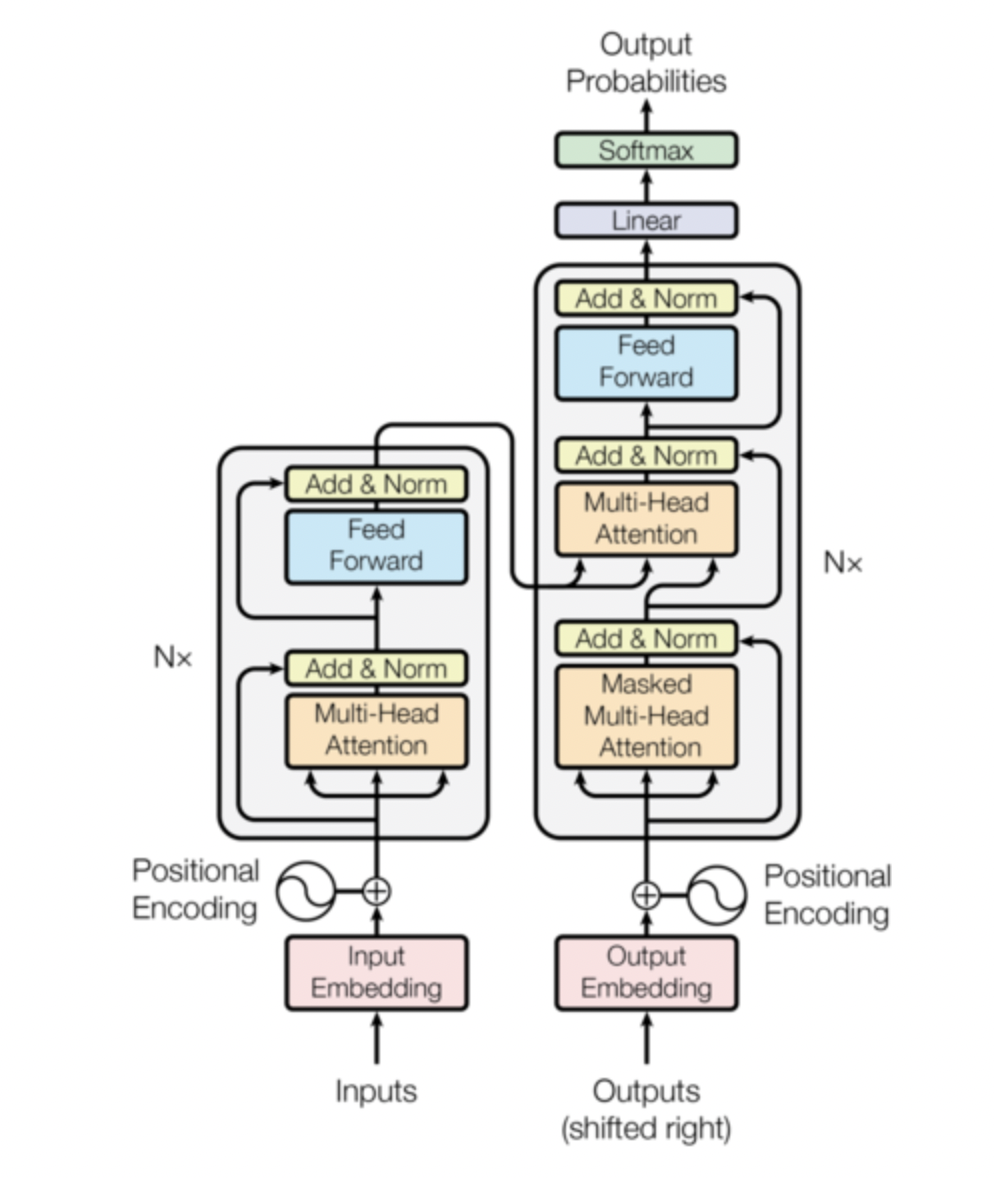

In [ ]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

#Architecture

>Encoder 

>Decoder 

>Attention

>Positon-Wise Feed Forward Network 

>Embedding 

>Softmax 

>Position Encoding

>Full Model 

In [5]:
class EncoderDecoder(nn.Module):
  """What do we use this for? 
  Class for Encoder-Decoder"""
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
      super(EncoderDecoder.self).__init__()
      self.encoder = encoder
      self.decoder = decoder
      self.src_embed = src_embed
      self.tgt_embed = tgt_embed 
      self.generator = generator 

  def forward(self, src, tgt, src_mask, tgt_mask):
    "Encode the mask src and target sequences"
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
  
  def encode(self, src, src_mask):
    return self.encoder(self.src_embed(src), src_mask)

  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)



In [6]:
class Generator(nn.Module):
  "Generator class for linear and softmax generation step"
  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)
    

#Encoder and Decoder 

In [31]:
def clones(module, N):
  "We want to produce N layers in encoder."
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [8]:
class Encoder(nn.Module):
  "In Transformer, Encoder is stack of N layers"
  "Layer Norm -> normalize distribution in layers"
  "Gives smooth gradient"
  def __init__(self, layer, N):
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)
  
  def forward(self, x, mask):
    "Pass input through each layer in turn"
    for layer in self.layers: 
      x = layer(x, mask)
    return self.norm(x)
    



In [ ]:
#Residual Connection - Skip Connection
#Learn Residual Function
#Reference to input 
#F(X) := H(x) - x


In [39]:
class LayerNorm(nn.Module):
  def __init__(self, features, eps=1e-6):
    super(LayerNorm, self).__init__()
    self.a_2 = nn.parameters(torch.ones(features))
    self.b_2 = nn.parameters(torch.zeros)
    self.eps = eps 
  def forward(self,x):
    mean = x.mean(-1, keepdmin=True)
    std=x.std(-1, keepdim=True)
    return self.a_2 * (x-mean)/(std+self.eps)+self.b_2 


In [ ]:
#LayerNorm (x + Sublayer(x))
#Sublayer(x) is function by sub-layer 
#Apply Drop-out to sublayer 
#Dimension of sub-layers = 512

In [12]:
class SublayerConnection(nn.Module):
  """Residual Connection are skip connection
  learns residual function, instead of unreferenced function
  Residual Connection goes to layer norm"""

  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    "Apply Residual connection to Sublayer with Same Size"
    return x + self.dropout(sublayer(self.norm(x)))
    


In [13]:
class EncoderLayer(nn.Module):
  "Recall, Encoder consists of self-attention layer and feed forward layer"
  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward 
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self, x, mask):
    x = self.sublayer[0](x, lambda x: self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)




#Decoder

In [16]:
#Decoder 
#Decoder consists of stack of N=6 layers
#Layers are identical 
#Encoder has two sub-layers in Encoder Layer 
#Decoder has Third-Sub-Layer 
#That performs multi-head attention 
#Multi-head attention is performed over output of encoder stack 
#Residual connection is around sub-layers 
#Layer Normalization 

class Decoder(nn.Module):
  def __init__(self, layer, N):
    super(Decoder, self).__init__() 
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers: 
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x) 

In [17]:
#Modify Self-Attention Sub-Layer 
#Prevent Subsequent position from attending 
#Masking + Output Embedding
# Offset by One Positon 
#Prediction of position i 
#Depends on known outputs at positon less than i 

class DecoderLayer(nn.Module):
  "Decoder consists of self-attention, src-attn and feed forward"
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn 
    self.src_attn = src_attn 
    self.feedforward = feed_forward 
    self.sublayer = clones(SublayerConnection(size, dropout), 3)
  
  def forward(self, x, memory, src_mask, tgt_mask):
    m = memory
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x = self.sublayer[1] (x, lambda x: self.src_attn(x, m, m, src_mask))
    return self.sublayer[2](x, self.feed_forward)

In [19]:
def subsequent_mask(size): 
  "Mask out subsequent position"
  attn_shape = (1, size, size)
  subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  return torch.from_numpy(subsequent_mask) == 0
  

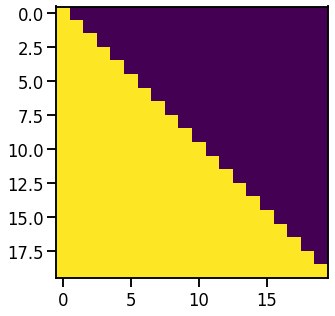

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

#Attention Mechanism 

1. Attention Function 

2. Map a Query 

3. With Set of Key-Value Pair 

4. Towards an Output 

5. Query 

6. Key 

7. Value 

8. Output are Vectors

9. Output is weighted sum of values 

10. Weight is computed 

11. As Compatibility Function 

12. With Query and Key 

#Scaled Dot Product Attention 

13. Input = Query, Keys of Dimension d(k)

14. Value of Dimension, D(v) 

15. Compute Dot Product of Query 

16. Query with Keys 

17. Divide / √ d(k) 

18. Apply Softmax 

19. Get Weight of Values 



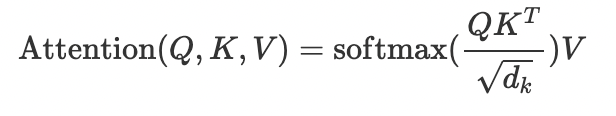

In [22]:
def attention(query, key, value, mask=None, dropout=None):
  "Scaled Dot Product Attention"
  d_k = query.size(-1)
  scores = torch.matmul(query, key.transpose(-2, -1)) \
    / math.sqrt(d_k)
  if mask is not None: 
    scores = scores.masked_fill(mask==0, -1e9)
  p_attn = F.softmax(scores, dim=-1)
  if dropout is not None: 
    p_attn = dropout(p_attn)
  return torch.matmul(p_attn, value), p_attn 
  


1. Additive Attention 
2. Dot Product Attention 
3. Dot Product [doesn't include scaling factor of 1 / sqrt (d(k) 
4. Additive attention, compute compability function 
5. Send to Feed forward network 
6. Send to Single Layer 

7. When two are similiar 
8. Dot product attention is faster 



#Multihead Attention 


1. Multihead Attention

2. Q, K, V

3. Concat(head1... headh) W(0)

4. Each head(i) = Attention(QW(qi), KW(ik), VW(vi)

5. Projection are Parameter Matrices 


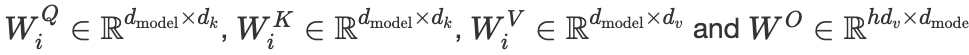

6. Where h = 8 parallel attention layer or head

We use the dimension, 

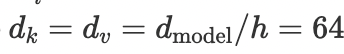

In [24]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

#Multi-head Attention

1. Encoder-Decoder Attention
2. Query from Decoder Layer 
3. Memory Key and Value 
4. Is taken from Output of Encoder 
5. Gives ability 
6. of Decoder to Attend over positions 
7. In Input Sequence 


B. 

1. Encoder has self-attention 

2. Self-attention has keys, values, queries 

3. Self-attention layers in decoder 

4. Lets position in decoder to attend all positions 

5. Prevent left-ward flow to preserve

6. Auto-regressive property 

7. Scaled-dot attention maksing out (-infinity) 


#Position Wise Feed Forward Networks

1. Each layer in Encoder 

2. And Decoder 

3. Consists of Fully-Connected Feed Forward Network 

4. Apply it seperately to each position 

5. And Identically 

6. Two Linear Transformation 

7. ReLU activation 

8. We have two convolution 

9. Kernel Size = 1 

10. Dimension of Input 

11. Dimension of Output 

12. We both both as 512 

13. Dimension of Inner Layer 

14. We have it as 2048 



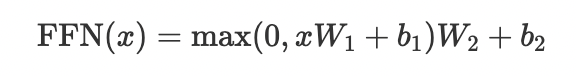

In [25]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# Embedding and Softmax



In [26]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

#Position Encoding

In [27]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

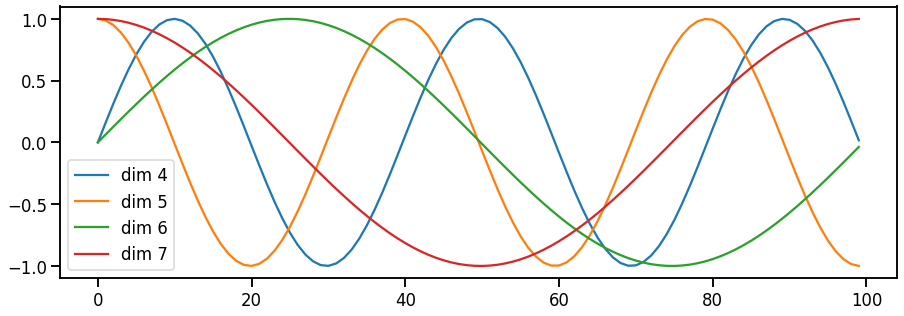

In [28]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

#Transformer Model 

In [29]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [40]:
# Small example model.
tmp_model = make_model(10, 10, 2)

AttributeError: ignored